In [1]:
import sys
sys.path.insert(1, '../')
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

import GuitarTrainer as gt

fname = "../recorded/data.txt"
inter_start = 3000
inter_end = 40960
sample_rate = 2500.0
sample_length = 500
min_freq = 70
max_freq = 1000

## Reading the file

In [2]:
y = gt.readFile(fname)
x = [i/sample_rate for i in range(len(y))]

X = np.array(x[inter_start:inter_end])
Y = np.array(y[inter_start:inter_end]) - 2.5

## Plot and choosing the intervals

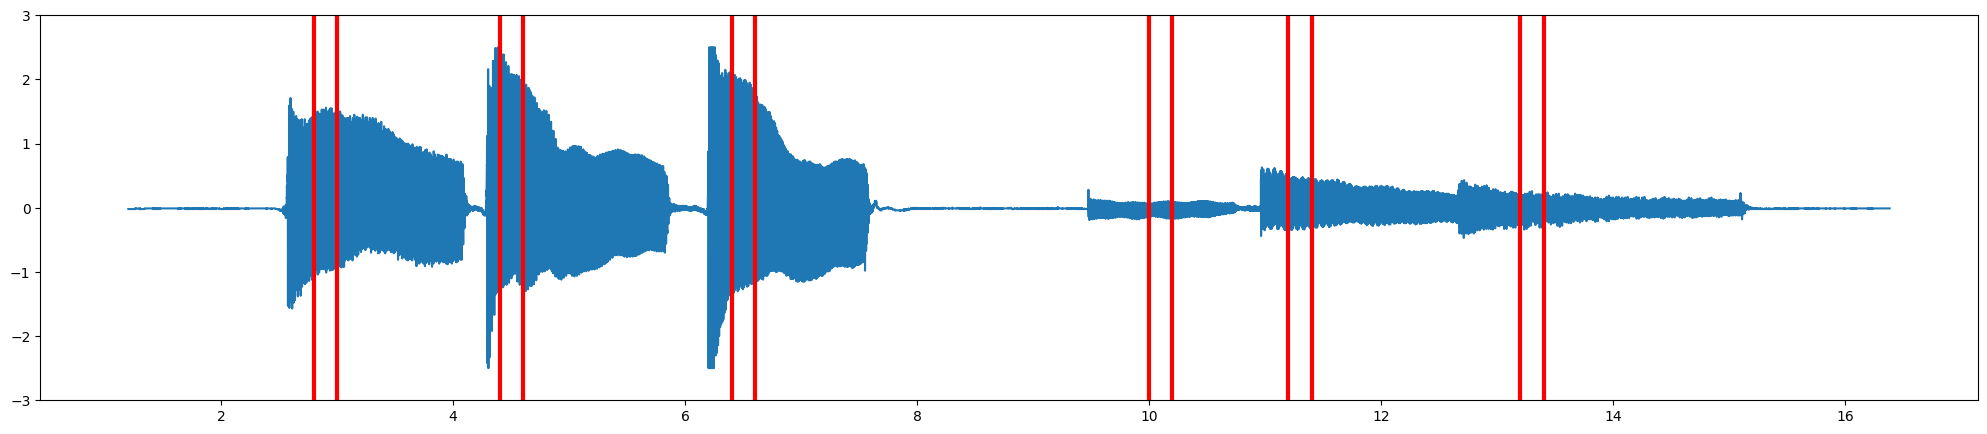

In [3]:
fig = plt.figure(figsize=(25, 5), dpi=100)
plt.ylim(-3,3)
plt.plot(X, Y)

intervals = [4000, 8000, 13000, 22000, 25000, 30000]
expected = [82, 98, 110, 330, 247, 196]

for istart in intervals:
    gt.plotInterval(X, istart, istart+sample_length)

plt.show()
ipd.Audio(Y, rate=sample_rate)

### Denoising

In [4]:
from skimage.restoration import denoise_wavelet
# VisuShrink / BayesShrink
Y_denoise = denoise_wavelet(Y, method='BayesShrink', mode='soft', 
                    wavelet_levels=3, wavelet='sym8', rescale_sigma='True')
ipd.Audio(Y_denoise, rate=sample_rate)

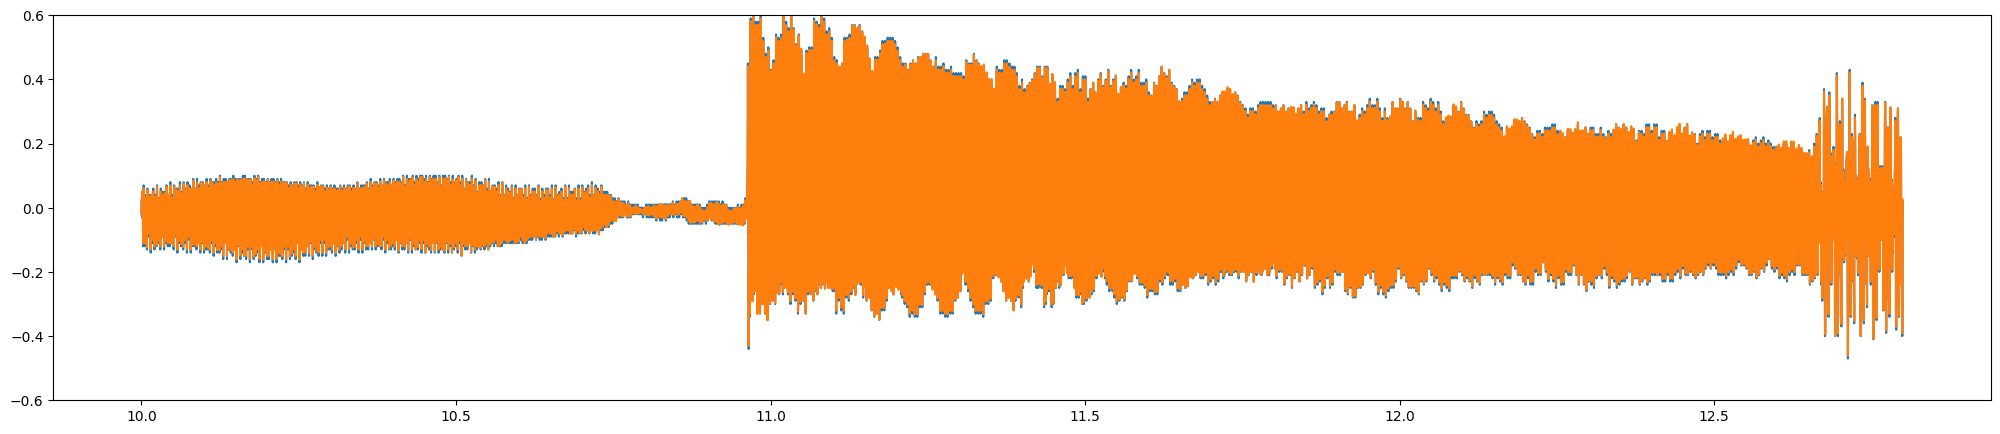

In [5]:
i = 22000
j = 29000
fig = plt.figure(figsize=(25, 5), dpi=100)
plt.ylim(-0.6,0.6)
plt.plot(X[i:j], Y[i:j])
plt.plot(X[i:j], Y_denoise[i:j])

### Filtering

In [6]:
import scipy.io.wavfile
import scipy.signal

In [7]:
# https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = scipy.signal.butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = scipy.signal.sosfilt(sos, data)
        return y

In [8]:
# b, a = scipy.signal.butter(3, 0.45)
# Y_filtered = scipy.signal.filtfilt(b, a, Y_denoise)

In [9]:
Y_filtered = butter_bandpass_filter(Y_denoise, min_freq, max_freq, sample_rate)

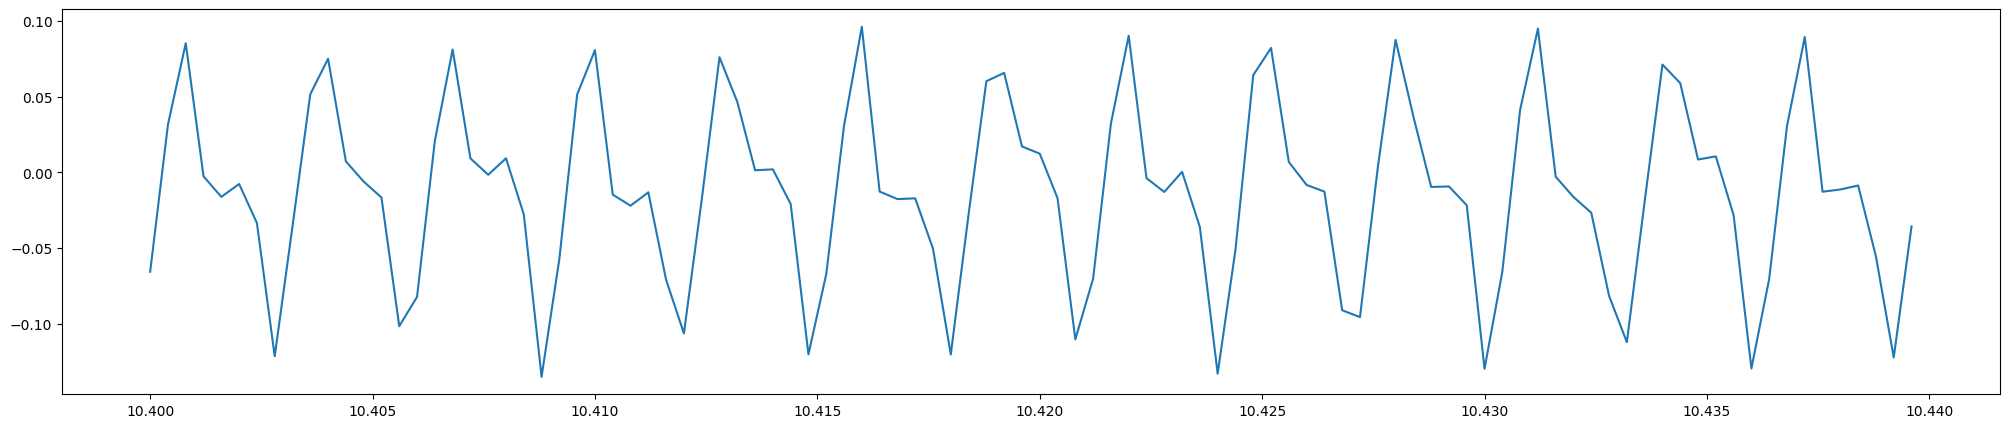

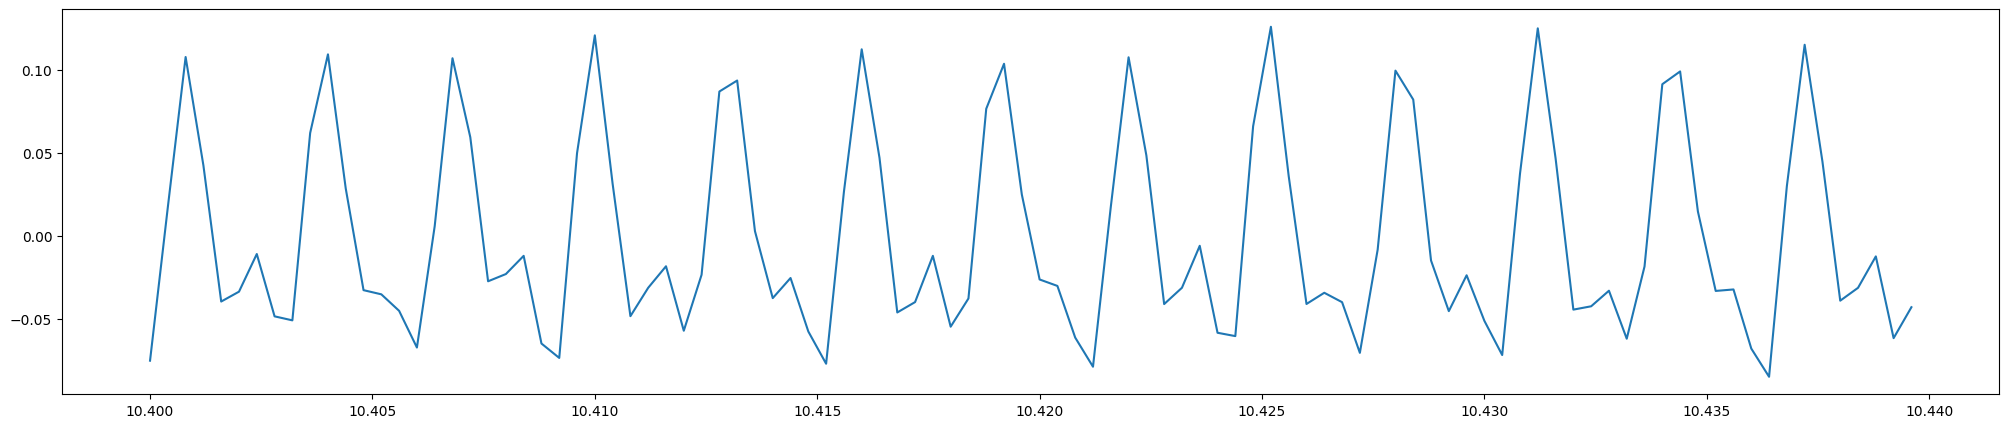

In [10]:
i = 23000
p = 100
fig = plt.figure(figsize=(25, 5), dpi=100)
plt.plot(X[i:i+p],Y_denoise[i:i+p])
plt.show()

fig = plt.figure(figsize=(25, 5), dpi=100)
plt.plot(X[i:i+p],Y_filtered[i:i+p])
plt.show()

In [11]:
ipd.Audio(Y_filtered, rate=sample_rate)

In [12]:
Y = Y_filtered

## Slicing

In [13]:
Slices = {'X': list(), 'Y': list()}
Slices['X'] = [gt.slice(X, istart, istart+sample_length) for istart in intervals]
Slices['Y'] = [gt.slice(Y, istart, istart+sample_length) for istart in intervals]

## FFT

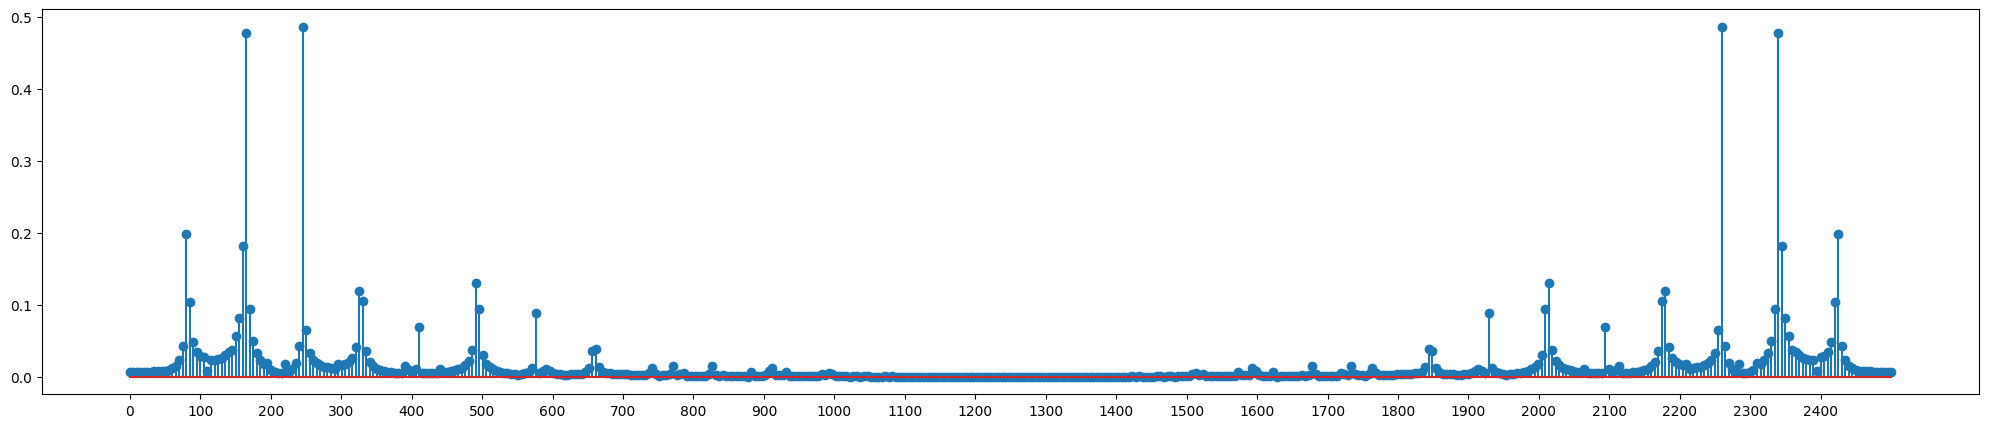

[80.0, 85.0, 160.0, 165.0, 170.0, 245.0, 325.0, 330.0, 490.0, 495.0]
Max          :  245.0
Calculated   :  82.5
Expected     :  82



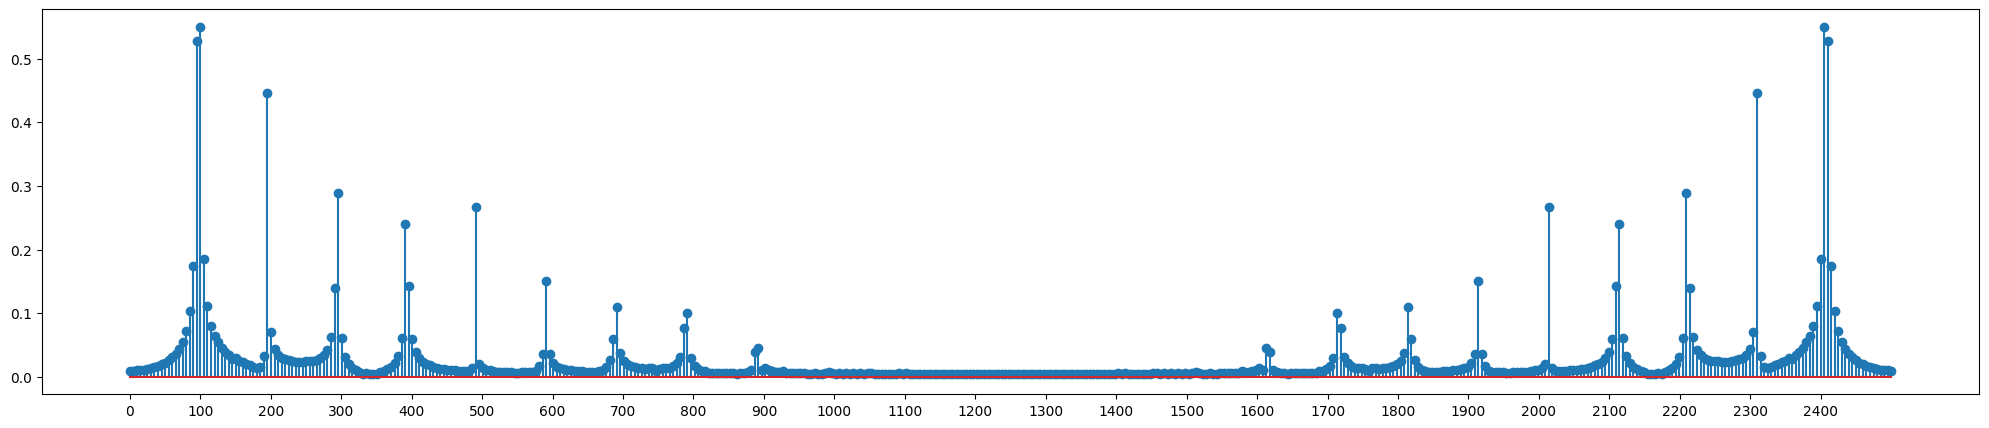

[90.0, 95.0, 100.0, 105.0, 195.0, 390.0, 395.0]
Max          :  100.0
Calculated   :  97.5
Expected     :  98



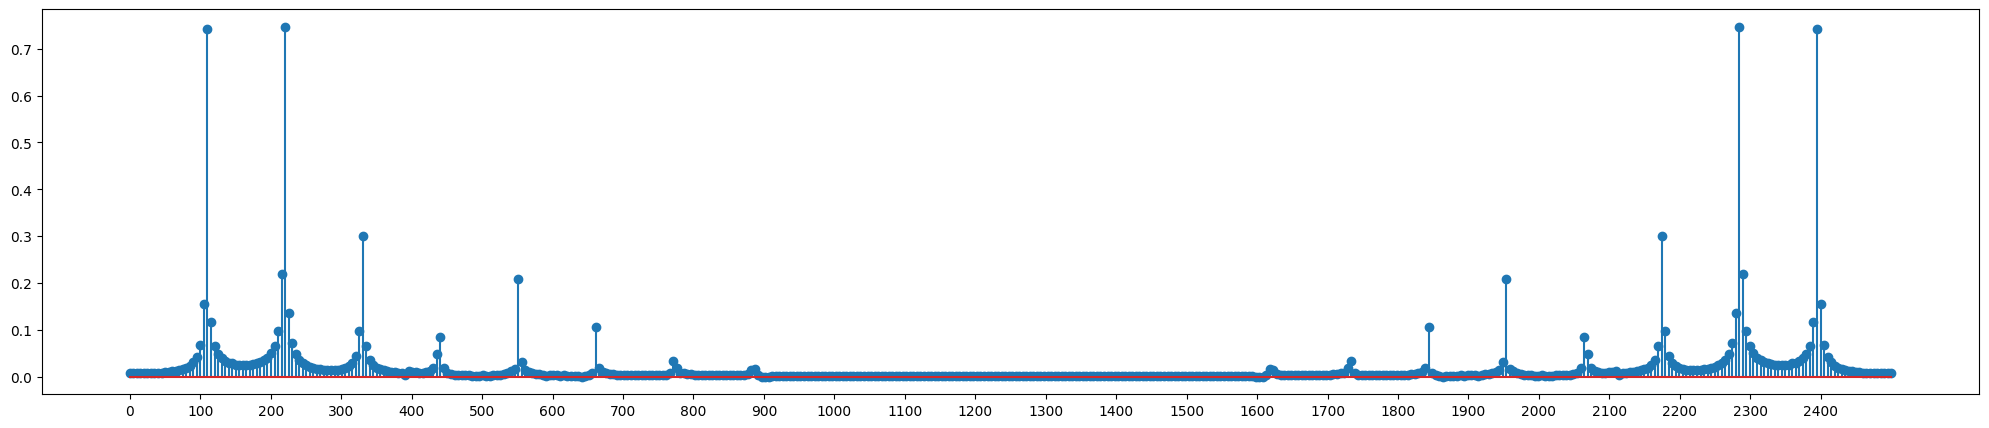

[105.0, 110.0, 115.0, 210.0, 215.0, 220.0, 225.0, 330.0]
Max          :  220.0
Calculated   :  110.0
Expected     :  110



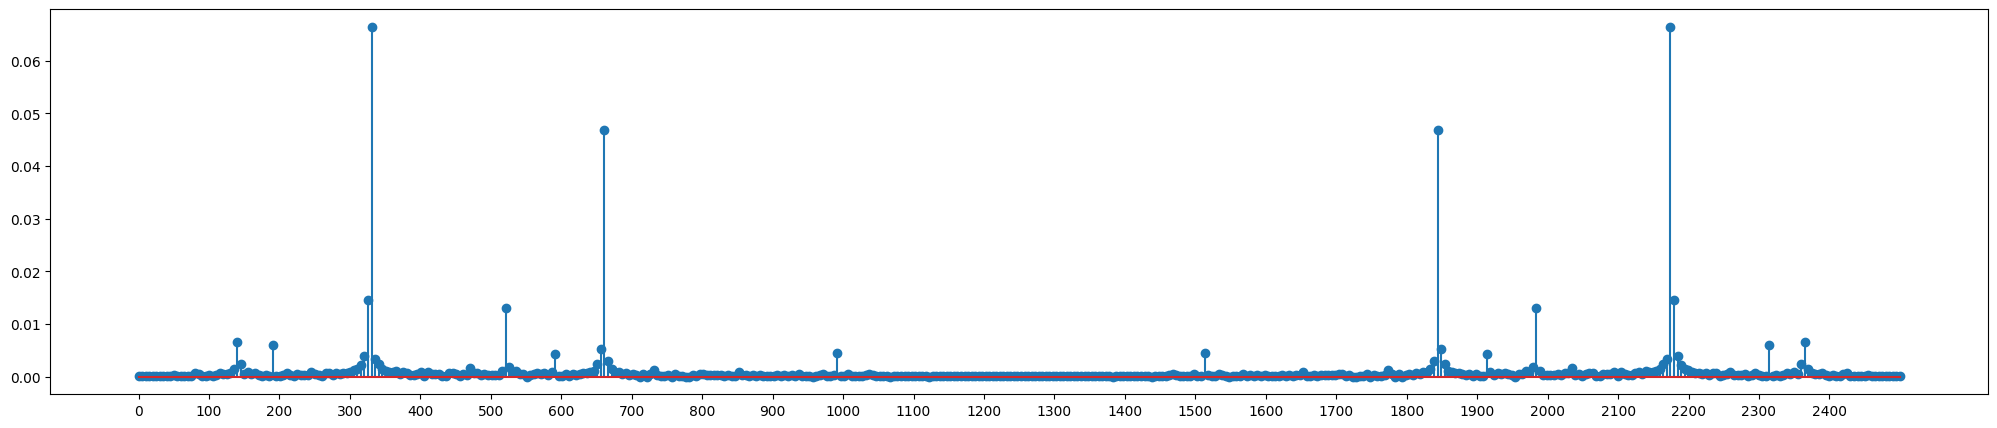

[320.0, 325.0, 330.0, 655.0, 660.0]
Max          :  330.0
Calculated   :  325.0
Expected     :  330



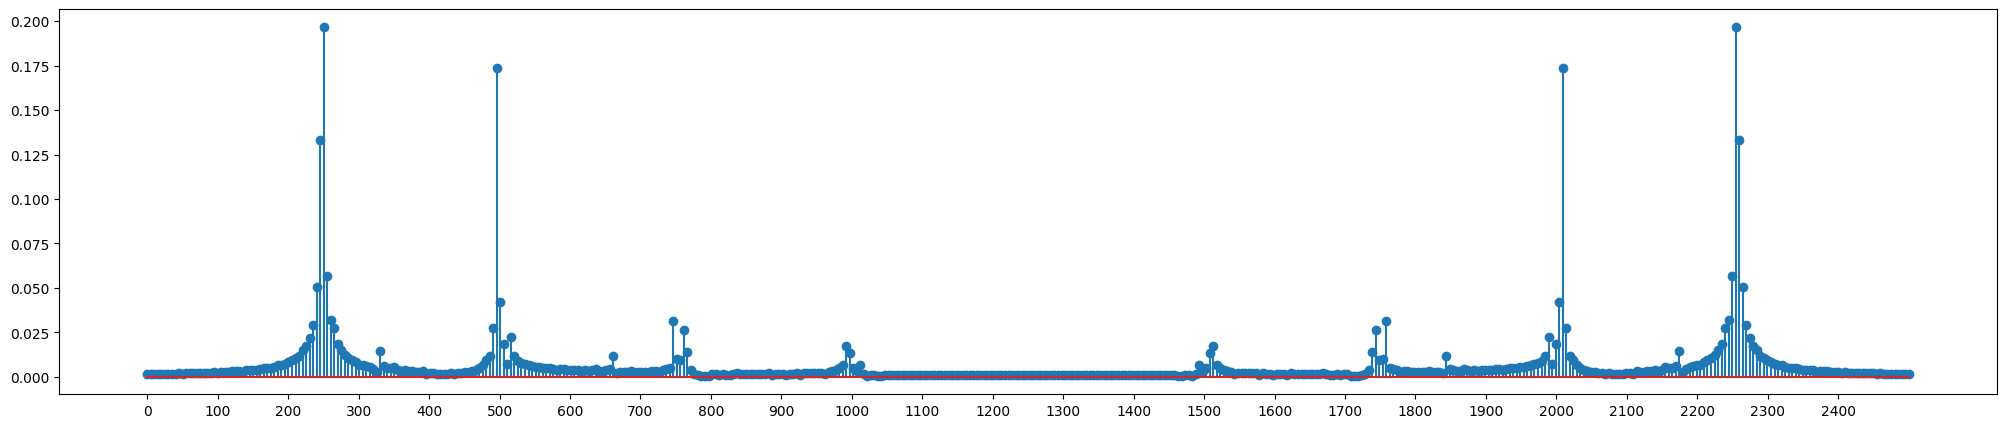

[235.0, 240.0, 245.0, 250.0, 255.0, 260.0, 265.0, 495.0, 500.0]
Max          :  250.0
Calculated   :  250.0
Expected     :  247



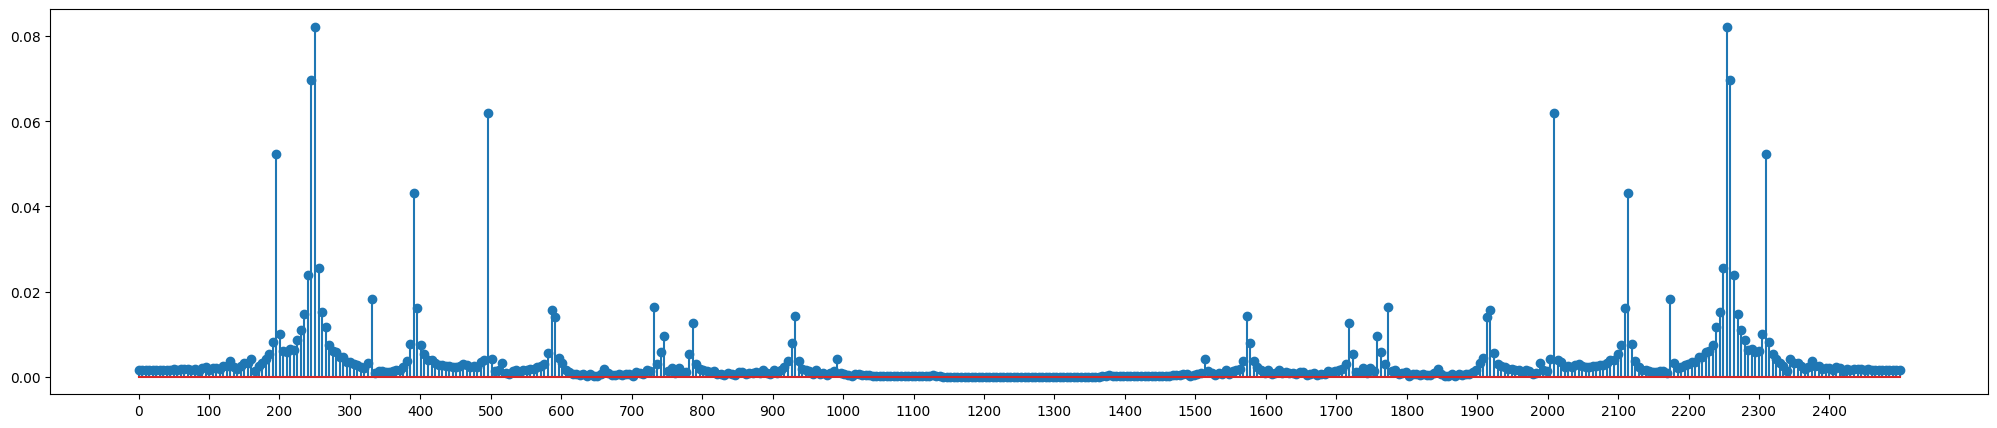

[195.0, 240.0, 245.0, 250.0, 255.0, 390.0, 395.0, 495.0]
Max          :  250.0
Calculated   :  195.0
Expected     :  196



In [14]:
for i, ySlice in enumerate(Slices['Y']):
    gt.plotStem(ySlice, expected=expected[i])

## TODO's

- filtry - odszumianie
- porządna metoda klasyfikacji dźwięków

## Archival

In [15]:
def plot_stem(y,intrv=(0,len(y)),sr=2500):
    y = y[intrv[0]:intrv[1]]
    c = abs(np.fft.fft(y))
    n = len(y)
    #fr = abs(np.fft.fftfreq(len(y)))
    # print(f"samples:{n}")
    # c = c/n * 2
    freqs = np.linspace(0,sr,n)
    #freqs = np.array(range(0,n))
    #freqs = np.array(range(0,n))/4 # 0/4 1/4 2/4 ...

    fig = plt.figure(figsize=(25, 5), dpi=100)
    plt.stem(freqs, c)
    # plt.xticks(freqs[:20])
    i = np.argmax(c[:-n//2]) 
    print(max(c))
    print(i)
    #print(max(y))
    print(f"F:{i/n * sr}")
    print(freqs[i])
    #print(c)
    #print(freqs)
    

In [16]:
def plot_stem3(y, intrv=(0,len(y)), sr=2500, expected=82):
    c = abs(np.fft.fft(y))
    n = len(y)
    c = c/n * 2
    freqs = np.linspace(0,sr,n)
    #freqs = np.array(range(0,sr))/n*sr
    #freqs = np.array(range(0,n))/4 # 0/4 1/4 2/4 ...

    fig = plt.figure(figsize=(25, 5), dpi=100)
    plt.stem(freqs[intrv[0]:intrv[1]], c[intrv[0]:intrv[1]])
    plt.xticks(np.arange(0,2500,100))
    plt.show()
    
    ind = np.argpartition(c[1:-n//2], -10)[-10:]
    print(*sorted([round(indx/n * sr, 2) for indx in ind]))
    print(expected,'\n\n\n')
    # i = np.argmax(c[:-n//2]) 
    # print(f"F:{i/n * sr} i:{i}\n\n\n")
    # print(freqs[i], "\n\n\n\n")
    # TODO filtry - szumy


In [17]:
def plot_stem2(x):
    c = np.fft.fft(x)
    n = len(c)
    fr = np.array(range(0,n))/4 # 0/4 1/4 2/4 ...
    condition = (fr < 600)# & (fr > 100)
    yy = np.abs(c[condition])
    xx = fr[condition]

    a = np.argmax(yy)
    f = xx[a]
    plt.plot(xx,yy)
    plt.axvline(x=f,color='r')
    plt.show()
    print(f"{f} Hz\n\n\n\n")

#plot_stem2(yslice)